# Binary Classification of Insurance Selling

The aim of this workbook is train a model to predict whether customers respond positively to an automobile insurance offer.

url: https://www.kaggle.com/competitions/playground-series-s4e7/overview

# Lib Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dask.dataframe as dd

In [2]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

In [3]:
RANDOM_STATE = 32
Y_COLUMN = 'Response'
TEST_SIZE = 0.25

In [4]:
import os

TRAIN_DATASET_DIR = '/kaggle/input/playground-series-s4e7/train.csv' if os.path.exists('/kaggle/input/') else 'train.csv'
TEST_DATASET_DIR = '/kaggle/input/playground-series-s4e7/test.csv' if os.path.exists('/kaggle/input/') else 'test.csv'

print(f"train dataset dir: {TRAIN_DATASET_DIR}")
print(f"test dataset dir: {TEST_DATASET_DIR}")

train dataset dir: /kaggle/input/playground-series-s4e7/train.csv
test dataset dir: /kaggle/input/playground-series-s4e7/test.csv


## 1. EDA

### 1.1 Train and Test Dataset Loading

The aim of this section is to load the train and test datasets, in order to investigate missing data and general trends.

In [5]:
train_df = dd.read_csv(TRAIN_DATASET_DIR)

In [6]:
train_df = train_df.compute()

In [7]:
train_df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


In [8]:
test_df = dd.read_csv(TEST_DATASET_DIR)
test_df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,11504798,Female,20,1,47.0,0,< 1 Year,No,2630.0,160.0,228
1,11504799,Male,47,1,28.0,0,1-2 Year,Yes,37483.0,124.0,123
2,11504800,Male,47,1,43.0,0,1-2 Year,Yes,2630.0,26.0,271
3,11504801,Female,22,1,47.0,1,< 1 Year,No,24502.0,152.0,115
4,11504802,Male,51,1,19.0,0,1-2 Year,No,34115.0,124.0,148


Train Data Null and Dtype checks

In [9]:
train_df.isna().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [10]:
train_df[Y_COLUMN].value_counts(normalize=True)

Response
0    0.877003
1    0.122997
Name: proportion, dtype: float64

There is a clear bias in this dataset which will need to be address with under / over sampling.

In [11]:
train_df.dtypes

id                        int64
Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

Test Data Null and Dtype checks

In [12]:
test_df.isna().sum().compute()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
dtype: int64

There doesn't seem to be any missing or unusual data so we can proceed with the EDA of the training Dataset.

### 1.2 EDA

In [13]:
train_df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


I'm going to start by reviewing the distribution of Driving License values.

In [14]:
train_df['Driving_License'].value_counts(normalize=True)

Driving_License
1    0.998022
0    0.001978
Name: proportion, dtype: float64

Over 99% of the dataset has a driving license. which makes sense as companies wouldn't be targeting non-drivers for insurance. Leads me to conclude that this can potentially be removed from the dataset.

In [15]:
train_df['Gender'].value_counts(normalize=True)

Gender
Male      0.541351
Female    0.458649
Name: proportion, dtype: float64

Fairly even split between Male and Female.

In [16]:
train_df['Policy_Sales_Channel'].unique()

array([124.,  26., 152., 156., 160.,   8.,  31., 157.,  60., 122.,  15.,
        30., 147.,   1.,  63., 136., 154.,  18., 135., 151.,   3.,  10.,
        55., 108.,   7.,  29., 163.,  13., 133., 145.,  25.,  12., 109.,
        23.,  78.,   4., 153., 150., 146., 120., 107., 155.,  61.,  14.,
        45.,  11.,  19.,  24.,  52., 132., 125.,  59.,  16.,  22.,  56.,
        20., 148., 158., 159., 139.,   9., 113., 121.,  21., 111.,  64.,
       116., 103., 128.,  65.,  37.,  91., 129., 127., 106., 140.,  35.,
       131.,  17.,  93.,  90.,  36., 118.,  54.,  62., 138.,  42.,  46.,
        86.,  80.,  68., 119.,  94.,  48.,  47.,  83.,  97.,  70.,  53.,
        44., 114.,  98.,  88., 110.,  32., 126.,  96.,  99., 130.,  66.,
       105.,  51.,  38., 137.,  89.,  81.,  92., 117.,  73.,  69.,  49.,
        87.,  33.,  39.,  50., 123.,  75., 101., 115., 100.,  95.,  57.,
        71., 134.,  82.,   6.,  58., 104.,  41.,  40.,   2.,  79.,  34.,
        76.,  28.,  74.,  43.,  67.,  27., 112., 10

### 1.3 Train Dataset Feature Engineering

The first step is to analyse the current dataset to determine if features can be engineered. For starters, I'm going to investigate the object columns to determine whether they can be encoded.

In [17]:
train_df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


In [18]:
train_df['Gender'].value_counts()

Gender
Male      6228134
Female    5276664
Name: count, dtype: int64

There are only two values so these can be binary encoded.

In [19]:
train_df['Vehicle_Age'].value_counts()

Vehicle_Age
1-2 Year     5982678
< 1 Year     5044145
> 2 Years     477975
Name: count, dtype: int64

There are only three unique values for Vehicle Age, so these can also be encoded.

In [20]:
train_df['Vehicle_Damage'].value_counts()

Vehicle_Damage
Yes    5783229
No     5721569
Name: count, dtype: int64

Finally Vehicle Damage can also be binary encoded.

So to summarize, all of the object columns can be encoded. Vehicle Damage and Gender will be Binary Encoded, and Vehicle Age will be one hot encoded.

In [21]:
BINARY_COLS = ['Gender', 'Vehicle_Damage']
ONE_HOT_COLS = ['Vehicle_Age']

In [22]:
label_binarizer = LabelBinarizer()

In [23]:
train_df['Gender'] = train_df['Gender'].apply(lambda x: 0 if x == 'Male' else 1)
train_df['Vehicle_Damage'] = train_df['Vehicle_Damage'].apply(lambda x: 1 if x == 'Yes' else 0)

In [24]:
train_df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,0,21,1,35.0,0,1-2 Year,1,65101.0,124.0,187,0
1,1,0,43,1,28.0,0,> 2 Years,1,58911.0,26.0,288,1
2,2,1,25,1,14.0,1,< 1 Year,0,38043.0,152.0,254,0
3,3,1,35,1,1.0,0,1-2 Year,1,2630.0,156.0,76,0
4,4,1,36,1,15.0,1,1-2 Year,0,31951.0,152.0,294,0


In [25]:
vehicle_age_one_hot = pd.get_dummies(train_df['Vehicle_Age'])

In [26]:
train_df[vehicle_age_one_hot.columns] = vehicle_age_one_hot.values.astype(int)

In [27]:
train_df.drop(['Vehicle_Age', 'id'], axis=1, inplace=True)

In [28]:
train_df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,1-2 Year,< 1 Year,> 2 Years
0,0,21,1,35.0,0,1,65101.0,124.0,187,0,1,0,0
1,0,43,1,28.0,0,1,58911.0,26.0,288,1,0,0,1
2,1,25,1,14.0,1,0,38043.0,152.0,254,0,0,1,0
3,1,35,1,1.0,0,1,2630.0,156.0,76,0,1,0,0
4,1,36,1,15.0,1,0,31951.0,152.0,294,0,1,0,0


### 1.4 Numerical Col Analysis

The next step is to review the distribution of numerical columns

In [29]:
NUMERICAL_COLS = ['Age', 'Region_Code', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Region_Code'}>],
       [<Axes: title={'center': 'Annual_Premium'}>,
        <Axes: title={'center': 'Policy_Sales_Channel'}>],
       [<Axes: title={'center': 'Vintage'}>, <Axes: >]], dtype=object)

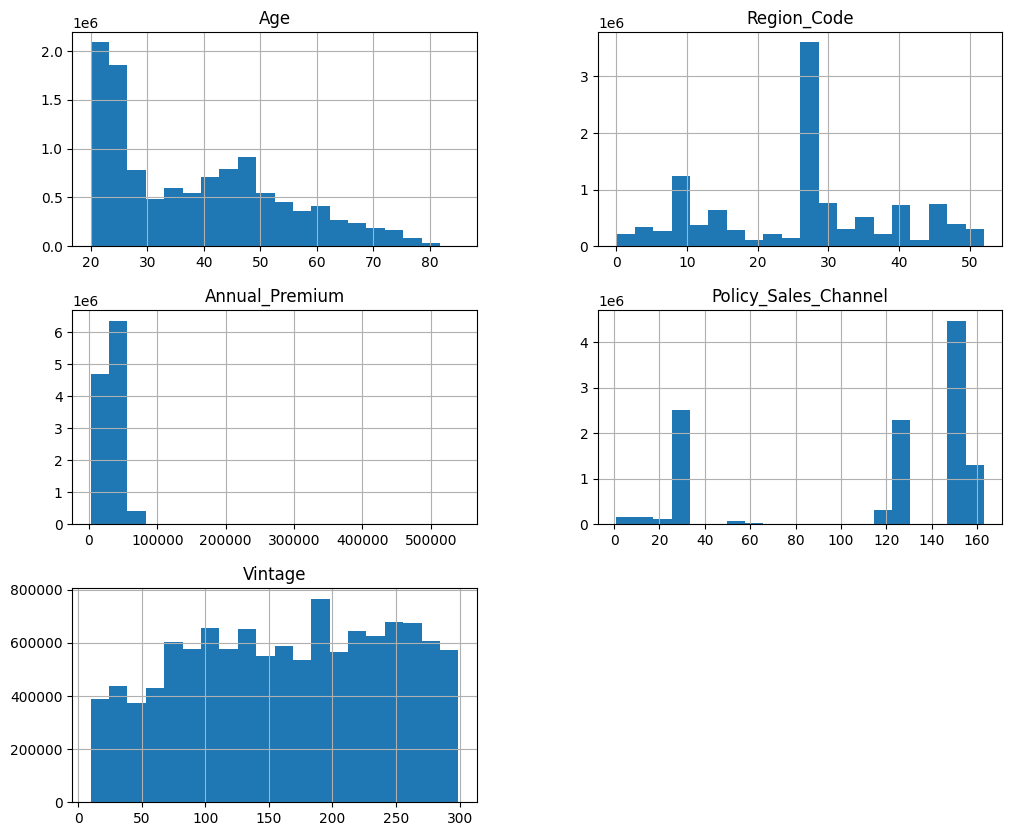

In [30]:
train_df[NUMERICAL_COLS].hist(bins=20, figsize=(12, 10))

Given the above distributions, it may be worth normalizing these columns.

### 1.5 Target vs Feature Analysis

The next step is to review the distribution of the Target Variable, and investigate the relationship between the rest of the features prior to model training.

In [31]:
corr = train_df.corr()

<Axes: >

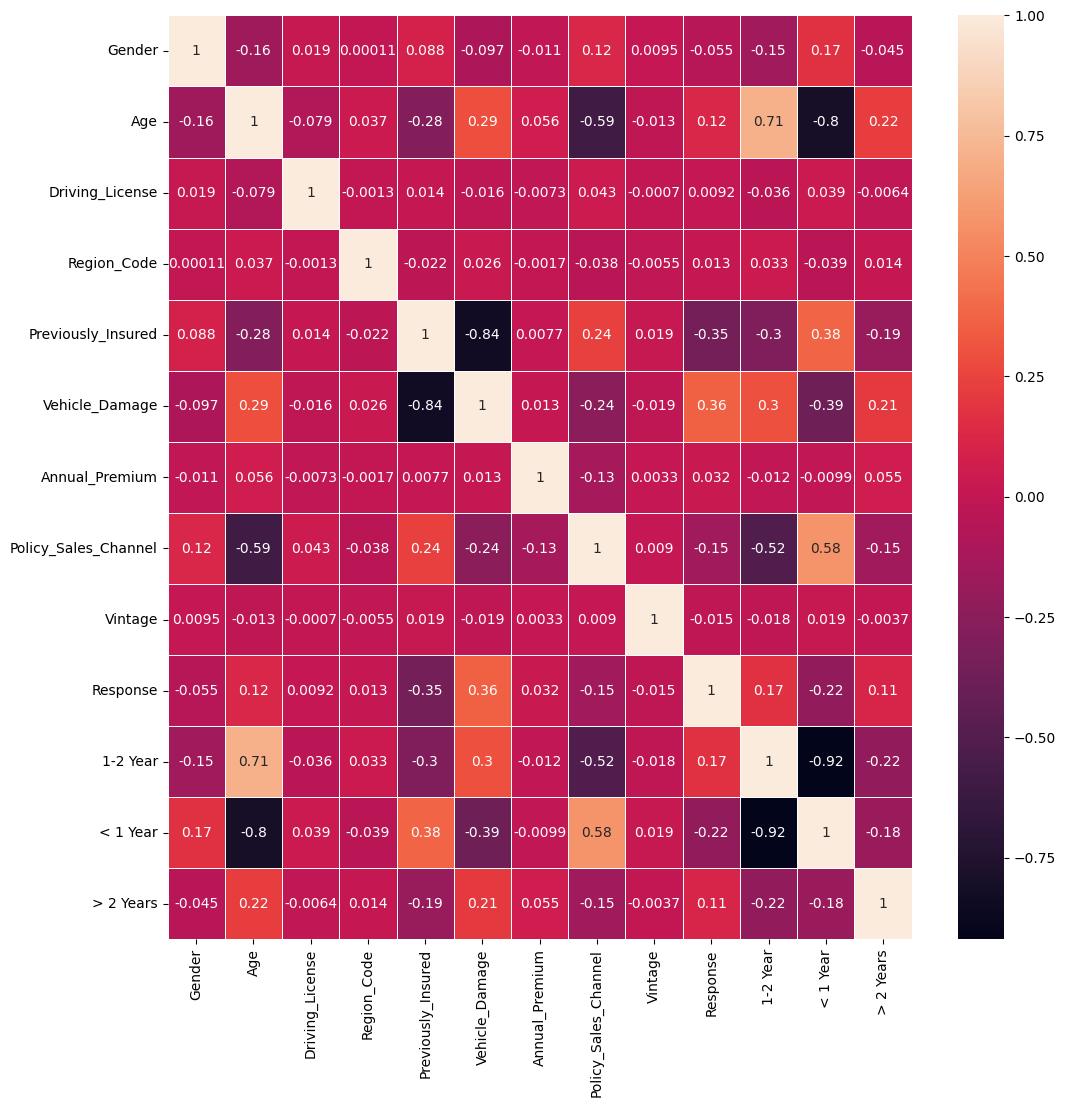

In [32]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corr, annot=True, linewidths=.5, ax=ax)

## 2. Pipeline Definition and Train Test Split

Define the preprocessors used for numerical, one hot and binary data.

In [33]:
numerical_transformer = Pipeline(
    steps=[
        ('ss', StandardScaler())
    ]
)

In [34]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, NUMERICAL_COLS)
    ],
    remainder='passthrough'
)

In [35]:
def create_lr_model(class_weight=None):
    lr_model = LogisticRegressionCV(Cs=4,
                                    cv=4,
                                    class_weight=class_weight,
                                    penalty='l2',
                                    random_state=RANDOM_STATE,
                                    max_iter=1000,
                                    n_jobs=-1)
    pipeline = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('classifier', lr_model)
        ]
    )
    return pipeline

In [36]:
X = train_df.drop(Y_COLUMN, axis=1)
y = train_df[Y_COLUMN]

In [37]:
X.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,1-2 Year,< 1 Year,> 2 Years
0,0,21,1,35.0,0,1,65101.0,124.0,187,1,0,0
1,0,43,1,28.0,0,1,58911.0,26.0,288,0,0,1
2,1,25,1,14.0,1,0,38043.0,152.0,254,0,1,0
3,1,35,1,1.0,0,1,2630.0,156.0,76,1,0,0
4,1,36,1,15.0,1,0,31951.0,152.0,294,1,0,0


In [38]:
ss = StratifiedShuffleSplit(n_splits=1, test_size=TEST_SIZE, random_state=RANDOM_STATE)
train_index, test_index = next(ss.split(X, y))

In [39]:
X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]

In [40]:
lr_model = create_lr_model()

## 3. Initial Model Training and Evaluation

In [41]:
lr_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['Age', 'Region_Code',
                                                   'Annual_Premium',
                                                   'Policy_Sales_Channel',
                                                   'Vintage'])])),
                ('classifier',
                 LogisticRegressionCV(Cs=4, cv=4, max_iter=1000, n_jobs=-1,
                                      random_state=32))])

In [42]:
y_pred = lr_model.predict(X_test)

In [43]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.93   2522435
           1       0.26      0.00      0.00    353765

    accuracy                           0.88   2876200
   macro avg       0.57      0.50      0.47   2876200
weighted avg       0.80      0.88      0.82   2876200



In [44]:
roc_auc_score(y_test, y_pred)

0.5000306626760633

## 4. Handling Data Imbalance with Class Weights

In this section, I am going to run GridSearch to determine the optimal class_weight to use within the Logistic Regression Model to determine whether this helps resolve the data imbalance and improve metrics.

In [45]:
lr_model_class = create_lr_model(class_weight={'0': 0.13, '1': 0.87})

In [46]:
lr_model_class.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['Age', 'Region_Code',
                                                   'Annual_Premium',
                                                   'Policy_Sales_Channel',
                                                   'Vintage'])])),
                ('classifier',
                 LogisticRegressionCV(Cs=4, class_weight={'0': 0.13, '1': 0.87},
                                      cv=4, max_iter=1000, n_jobs=-1,
                                      random_state=32))])

In [47]:
y_pred_class = lr_model_class.predict(X_test)

In [48]:
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.99      0.60      0.75   2522435
           1       0.25      0.96      0.40    353765

    accuracy                           0.65   2876200
   macro avg       0.62      0.78      0.57   2876200
weighted avg       0.90      0.65      0.71   2876200



In [49]:
roc_auc_score(y_test, y_pred_class)

0.7818464784808221

## 5. Handling Imbalanced Data using Undersampling

In [50]:
under_sampler = RandomUnderSampler(random_state=RANDOM_STATE)
X_under, y_under = under_sampler.fit_resample(X, y)

In [51]:
print(f"X shape before: {X.shape}, X_under shape: {X_under.shape}")
print(f"y shape before: {y.shape}, y_under shape: {y_under.shape}")

X shape before: (11504798, 12), X_under shape: (2830118, 12)
y shape before: (11504798,), y_under shape: (2830118,)


In [52]:
y.value_counts(normalize=True)

Response
0    0.877003
1    0.122997
Name: proportion, dtype: float64

In [53]:
y_under.value_counts(normalize=True)

Response
0    0.5
1    0.5
Name: proportion, dtype: float64

In [54]:
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(X_under, y_under, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [55]:
lr_model2 = create_lr_model()
lr_model2.fit(X_train_under, y_train_under)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['Age', 'Region_Code',
                                                   'Annual_Premium',
                                                   'Policy_Sales_Channel',
                                                   'Vintage'])])),
                ('classifier',
                 LogisticRegressionCV(Cs=4, cv=4, max_iter=1000, n_jobs=-1,
                                      random_state=32))])

In [56]:
y_pred_under = lr_model2.predict(X_test_under)
y_pred_under

array([0, 0, 1, ..., 1, 1, 1])

In [57]:
y_pred_under.shape

(707530,)

In [58]:
print(classification_report(y_test_under, y_pred_under))

              precision    recall  f1-score   support

           0       0.96      0.60      0.74    353818
           1       0.71      0.97      0.82    353712

    accuracy                           0.79    707530
   macro avg       0.83      0.79      0.78    707530
weighted avg       0.83      0.79      0.78    707530



In [59]:
roc_auc_score(y_test_under, y_pred_under)

0.785428035530624

## 6. Handling Data Imbalance using Over Sampling

In [60]:
smote_sampler = SMOTE(random_state=RANDOM_STATE)
X_smo, y_smo = smote_sampler.fit_resample(X, y)

In [61]:
y.value_counts(normalize=True)

Response
0    0.877003
1    0.122997
Name: proportion, dtype: float64

In [62]:
y_smo.value_counts(normalize=True)

Response
0    0.5
1    0.5
Name: proportion, dtype: float64

In [63]:
X_train_smo, X_test_smo, y_train_smo, y_test_smo = train_test_split(X_smo, y_smo, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [64]:
lr_model3 = create_lr_model()
lr_model3.fit(X_train_smo, y_train_smo)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  ['Age', 'Region_Code',
                                                   'Annual_Premium',
                                                   'Policy_Sales_Channel',
                                                   'Vintage'])])),
                ('classifier',
                 LogisticRegressionCV(Cs=4, cv=4, max_iter=1000, n_jobs=-1,
                                      random_state=32))])

In [65]:
y_pred_smo = lr_model3.predict(X_test_smo)

In [66]:
print(classification_report(y_test_smo, y_pred_smo))

              precision    recall  f1-score   support

           0       0.89      0.71      0.79   2521970
           1       0.76      0.92      0.83   2522900

    accuracy                           0.81   5044870
   macro avg       0.83      0.81      0.81   5044870
weighted avg       0.83      0.81      0.81   5044870



In [67]:
roc_auc_score(y_test_smo, y_pred_smo)

0.811398248407667

## 7. Kaggle Submission

In [68]:
#y_val_pred = lr_model3.predict(test_df)

In [69]:
#submission_df = pd.DataFrame({'id': test_df['id'], 'Response': y_val_pred})